Решение тестового задания на позицию дата-инженера

In [ ]:
#Сгенерируем датасет с помощью кода ниже
import random
import pandas as pd
import string
import datetime
import csv

def random_date(start, end):
    """
    This function will return a random datetime between two datetime
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = random.randrange(int_delta)
    return start + datetime.timedelta(seconds=random_second)




def dataset_generate(duplicate_percent, row_number, file_path):
    d1 = datetime.datetime.strptime('1/1/2000 00:00:00', '%m/%d/%Y %H:%M:%S')
    d2 = datetime.datetime.strptime('1/1/2025 00:00:00', '%m/%d/%Y %H:%M:%S')
    date2 = random_date(d1, d2)
    int2 = random.randint(1_000_000, 10_000_000)
    str2 = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
    df2 = (int2, date2, str2)
    with open(file_path, 'w', newline='') as f1:
        df1 = ('Numeric', 'DateTime', 'String')
        writer1 = csv.writer(f1)
        writer1.writerow(df1)

    with open(file_path, 'a+', newline='') as f:
        for i in range(row_number):
            writer2 = csv.writer(f)
            if i < row_number*(1-duplicate_percent):
                date1 = random_date(d1, d2)
                int1 = random.randint(1_000_000, 10_000_000)
                str1 = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
                df1 = (int1, date1, str1)
                writer2.writerow(df1)
            else:
                writer2.writerow(df2)




In [ ]:
dataset_generate(0.1, 100_000_000, 'datasetfile.csv')

In [ ]:
!pip3 install polars

   ---------------------------------------- 0.0/33.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/33.7 MB ? eta -:--:--
   - -------------------------------------- 1.6/33.7 MB 8.4 MB/s eta 0:00:04
   - -------------------------------------- 1.6/33.7 MB 8.4 MB/s eta 0:00:04
   - -------------------------------------- 1.6/33.7 MB 8.4 MB/s eta 0:00:04
   - -------------------------------------- 1.6/33.7 MB 8.4 MB/s eta 0:00:04
   - -------------------------------------- 1.6/33.7 MB 8.4 MB/s eta 0:00:04
   - -------------------------------------- 1.6/33.7 MB 8.4 MB/s eta 0:00:04
   -- ------------------------------------- 2.4/33.7 MB 1.4 MB/s eta 0:00:23
   ---- ----------------------------------- 4.2/33.7 MB 2.4 MB/s eta 0:00:13
   ---- ----------------------------------- 4.2/33.7 MB 2.4 MB/s eta 0:00:13
   ---- ----------------------------------- 4.2/33.7 MB 2.4 MB/s eta 0:00:13
   ---- ----------------------------------- 4.2/33.7 MB 2.4 MB/s eta 0:00:13
   ----- ----

In [ ]:
#Если датасет создан, то нужно смотреть код отсюда
import polars as pl

df = pl.read_csv("datasetfile.csv")

In [ ]:
#Check dataset size
df.select(pl.len())

len
u32
100000000


In [ ]:
print(df[0])

shape: (1, 3)
┌─────────┬─────────────────────┬────────────┐
│ Numeric ┆ DateTime            ┆ String     │
│ ---     ┆ ---                 ┆ ---        │
│ i64     ┆ str                 ┆ str        │
╞═════════╪═════════════════════╪════════════╡
│ 1584073 ┆ 2012-11-03 13:08:30 ┆ 0GW7EXT7QM │
└─────────┴─────────────────────┴────────────┘


In [ ]:
df = df.with_columns(
    pl.col("DateTime").str.to_datetime("%Y-%m-%d %H:%M:%S")
)
print(df[0])

shape: (1, 3)
┌─────────┬─────────────────────┬────────────┐
│ Numeric ┆ DateTime            ┆ String     │
│ ---     ┆ ---                 ┆ ---        │
│ i64     ┆ datetime[μs]        ┆ str        │
╞═════════╪═════════════════════╪════════════╡
│ 1584073 ┆ 2012-11-03 13:08:30 ┆ 0GW7EXT7QM │
└─────────┴─────────────────────┴────────────┘


In [ ]:
df.select(pl.len())

len
u32
100000000


In [ ]:
# 1. Удалить пустые/NA строки(все значения внутри строки пустые)
import functools
import operator

df = df.filter(~functools.reduce(operator.or_, map(lambda col: pl.col(col).is_null(), df.columns)))
df.select(pl.len())

len
u32
100000000


In [ ]:
# 2. Удалить дубликаты

#df1 = functools.reduce(lambda acc, col: acc.unique(subset=[col]), df.columns, df)
df1 = df.unique(maintain_order=True)
# Альтернативные способы, но не такие быстрые
#df1 = df.lazy().unique().collect()
#df = df.unique()
df1.select(pl.len())

len
u32
90000001


In [ ]:
df1.columns

['Numeric', 'DateTime', 'String']

In [ ]:
# 3. Строки, в которых нет цифр, сделать пустыми
df2 = df1.fill_null(not(pl.when(pl.col("String").str.contains(r'\d'))))
df2.select(pl.len())

len
u32
90000001


In [ ]:
# 4. Удалить записи в промежутке от 1 до 3 часов ночи
df3 = df2.filter(~(pl.col("DateTime").dt.hour().is_between(1, 3)))
df3.select(pl.len())

len
u32
78752743


Метрики

In [ ]:
# Подсчет уникальных строк для каждого часа

result = (
    df3.with_columns(
        pl.col("DateTime").dt.hour().alias("hour")  # Извлекаем часы
    )
    .group_by("hour")  # Группируем по часам
    .agg([
        pl.col("String").n_unique().alias("unique_strings_count"),  # Считаем уникальные строки
        pl.col("Numeric").mean().alias("mean_number"),  # Считаем среднее
        pl.col("Numeric").median().alias("median_number")  # Считаем медиану
    ]).sort('hour')
)
print(result)

shape: (21, 4)
┌──────┬──────────────────────┬─────────────┬───────────────┐
│ hour ┆ unique_strings_count ┆ mean_number ┆ median_number │
│ ---  ┆ ---                  ┆ ---         ┆ ---           │
│ i8   ┆ u32                  ┆ f64         ┆ f64           │
╞══════╪══════════════════════╪═════════════╪═══════════════╡
│ 0    ┆ 3747964              ┆ 5.4988e6    ┆ 5.497428e6    │
│ 4    ┆ 3749898              ┆ 5.4985e6    ┆ 5497623.5     │
│ 5    ┆ 3750158              ┆ 5.5024e6    ┆ 5505698.5     │
│ 6    ┆ 3749247              ┆ 5.4985e6    ┆ 5.497854e6    │
│ 7    ┆ 3749669              ┆ 5.4998e6    ┆ 5.500976e6    │
│ …    ┆ …                    ┆ …           ┆ …             │
│ 19   ┆ 3750267              ┆ 5.5000e6    ┆ 5.501764e6    │
│ 20   ┆ 3748059              ┆ 5.5005e6    ┆ 5.502151e6    │
│ 21   ┆ 3747678              ┆ 5.4987e6    ┆ 5.49913e6     │
│ 22   ┆ 3752024              ┆ 5.5013e6    ┆ 5.50259e6     │
│ 23   ┆ 3751927              ┆ 5.4999e6    ┆ 5.501686e

In [ ]:
"""
SQL-запрос

SELECT
    DATE_TRUNC('hour', DateTime) AS hour,  -- Округляем дату до часа
    AVG(Numeric) AS mean_value,  -- Среднее значение
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Numeric) AS median_value,  -- Медиана
    COUNT(DISTINCT String) AS unique_strings_count  -- Количество уникальных строк
FROM
    my_table
GROUP BY
    hour  -- Группируем по часу
ORDER BY
    hour;  -- Сортируем по часу
"""

Мерж

In [ ]:
df3.select("*")

Numeric,DateTime,String
i64,datetime[μs],str
1584073,2012-11-03 13:08:30,"""0GW7EXT7QM"""
4396077,2020-03-07 08:03:59,"""H6PEKHFJLA"""
4380505,2005-07-25 21:13:08,"""73ZESWDN3B"""
9060509,2003-12-25 13:38:22,"""F5IQ8C1C0I"""
2164494,2022-01-02 06:35:27,"""LRQW0MWWM6"""
…,…,…
1720222,2021-09-22 22:15:03,"""GEA1KPVDN8"""
9925223,2008-10-08 00:48:18,"""6B4J8FGAVI"""
2333335,2013-02-06 20:55:23,"""5W7L0E7MS3"""


In [ ]:
result1 = df3.join(result, left_on=(pl.col("DateTime").dt.round("1h").dt.hour().cast(pl.Int8)), right_on="hour", how="inner")
result1.select("*")

Numeric,DateTime,String,hour,unique_strings_count,mean_number,median_number
i64,datetime[μs],str,i8,u32,f64,f64
1584073,2012-11-03 13:08:30,"""0GW7EXT7QM""",13,3752881,5.4997e6,5.498572e6
4396077,2020-03-07 08:03:59,"""H6PEKHFJLA""",8,3752756,5.5017e6,5503175.5
4380505,2005-07-25 21:13:08,"""73ZESWDN3B""",21,3747678,5.4987e6,5.49913e6
9060509,2003-12-25 13:38:22,"""F5IQ8C1C0I""",14,3752093,5.4988e6,5.495908e6
2164494,2022-01-02 06:35:27,"""LRQW0MWWM6""",7,3749669,5.4998e6,5.500976e6
…,…,…,…,…,…,…
4472086,2004-03-20 19:49:58,"""48HC0GRB4U""",20,3748059,5.5005e6,5.502151e6
1720222,2021-09-22 22:15:03,"""GEA1KPVDN8""",22,3752024,5.5013e6,5.50259e6
2333335,2013-02-06 20:55:23,"""5W7L0E7MS3""",21,3747678,5.4987e6,5.49913e6


Аналитические метрики

Гистограмма

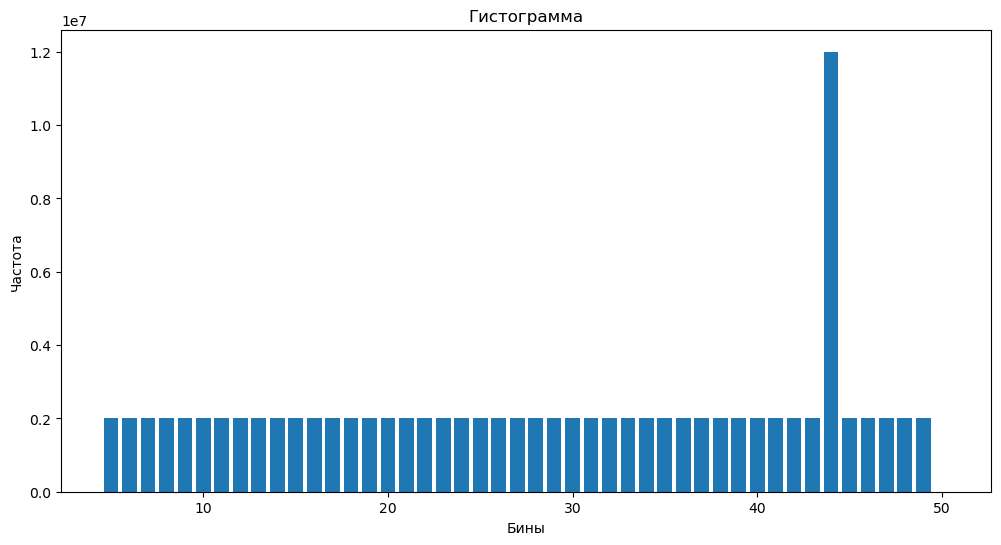

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

min_value = df.select(pl.col("Numeric").min()).item()
max_value = df.select(pl.col("Numeric").max()).item()

bins = np.linspace(min_value, max_value, 51)

hist = (
    df.with_columns((pl.col("Numeric") // (max_value / 50)).alias("bin"))
      .group_by("bin")
      .agg([pl.len().alias("count")])
)

plt.figure(figsize=(12, 6))
plt.bar(hist["bin"], hist["count"])
plt.title('Гистограмма')
plt.xlabel('Бины')
plt.ylabel('Частота')
plt.show()
# выброс берется из-за наличия дубликатов. Видно, что, не считая дубликатов, данные равномерно распределены

95% доверительный интервал для numeric

In [ ]:
data = df["Numeric"]

# Количество наблюдений
n = len(data)

# Среднее значение
mean = data.mean()

# Стандартное отклонение
std_dev = data.std(ddof=0)

# Стандартная ошибка среднего
sem = std_dev / n**0.5

# Коэффициент t-критерия Стьюдента для 95% доверительного интервала при числе степеней свободы n-1
from scipy.stats import t
alpha = 0.05
t_crit = t.ppf(1 - alpha/2, n-1)

# Доверительные границы
lower_bound = mean - sem * t_crit
upper_bound = mean + sem * t_crit

print(f'95% доверительный интервал для Numeric: ({lower_bound:.4f}, {upper_bound:.4f})')

95% доверительный интервал для Numeric: (5835322.0170, 5836365.6691)


Визуализация

Построение зависимости среднего в колонке Numeric от месяца

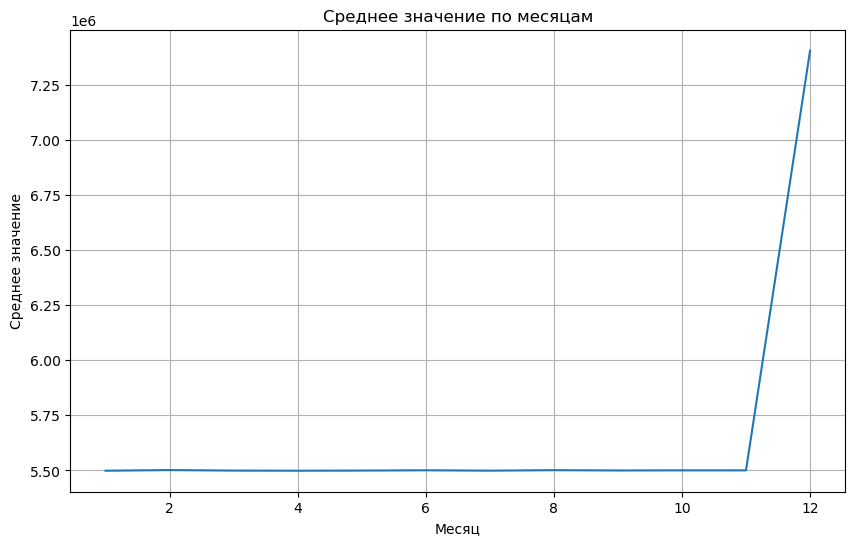

In [ ]:
# Группировка по месяцу и расчет среднего значения
grouped_df = (
    df.with_columns(
        pl.col("DateTime").dt.month().alias("month")  # Извлекаем часы
    )
    .group_by("month")  # Группируем по часам
    .agg([
        pl.col("Numeric").mean().alias("average_value"),  # Считаем среднее
    ]).sort('month')
)

# Отображение графика
plt.figure(figsize=(10, 6))
plt.plot(grouped_df["month"], grouped_df["average_value"])
plt.title("Среднее значение по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Среднее значение")
plt.grid(True)
plt.show()

Построение Heatmap по частотности символов в колонке string

In [2]:
# Эту часть задания лучше посчитать на TPU в Google Colab, так в несколько десятков раз быстрее
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("drive/My Drive/")

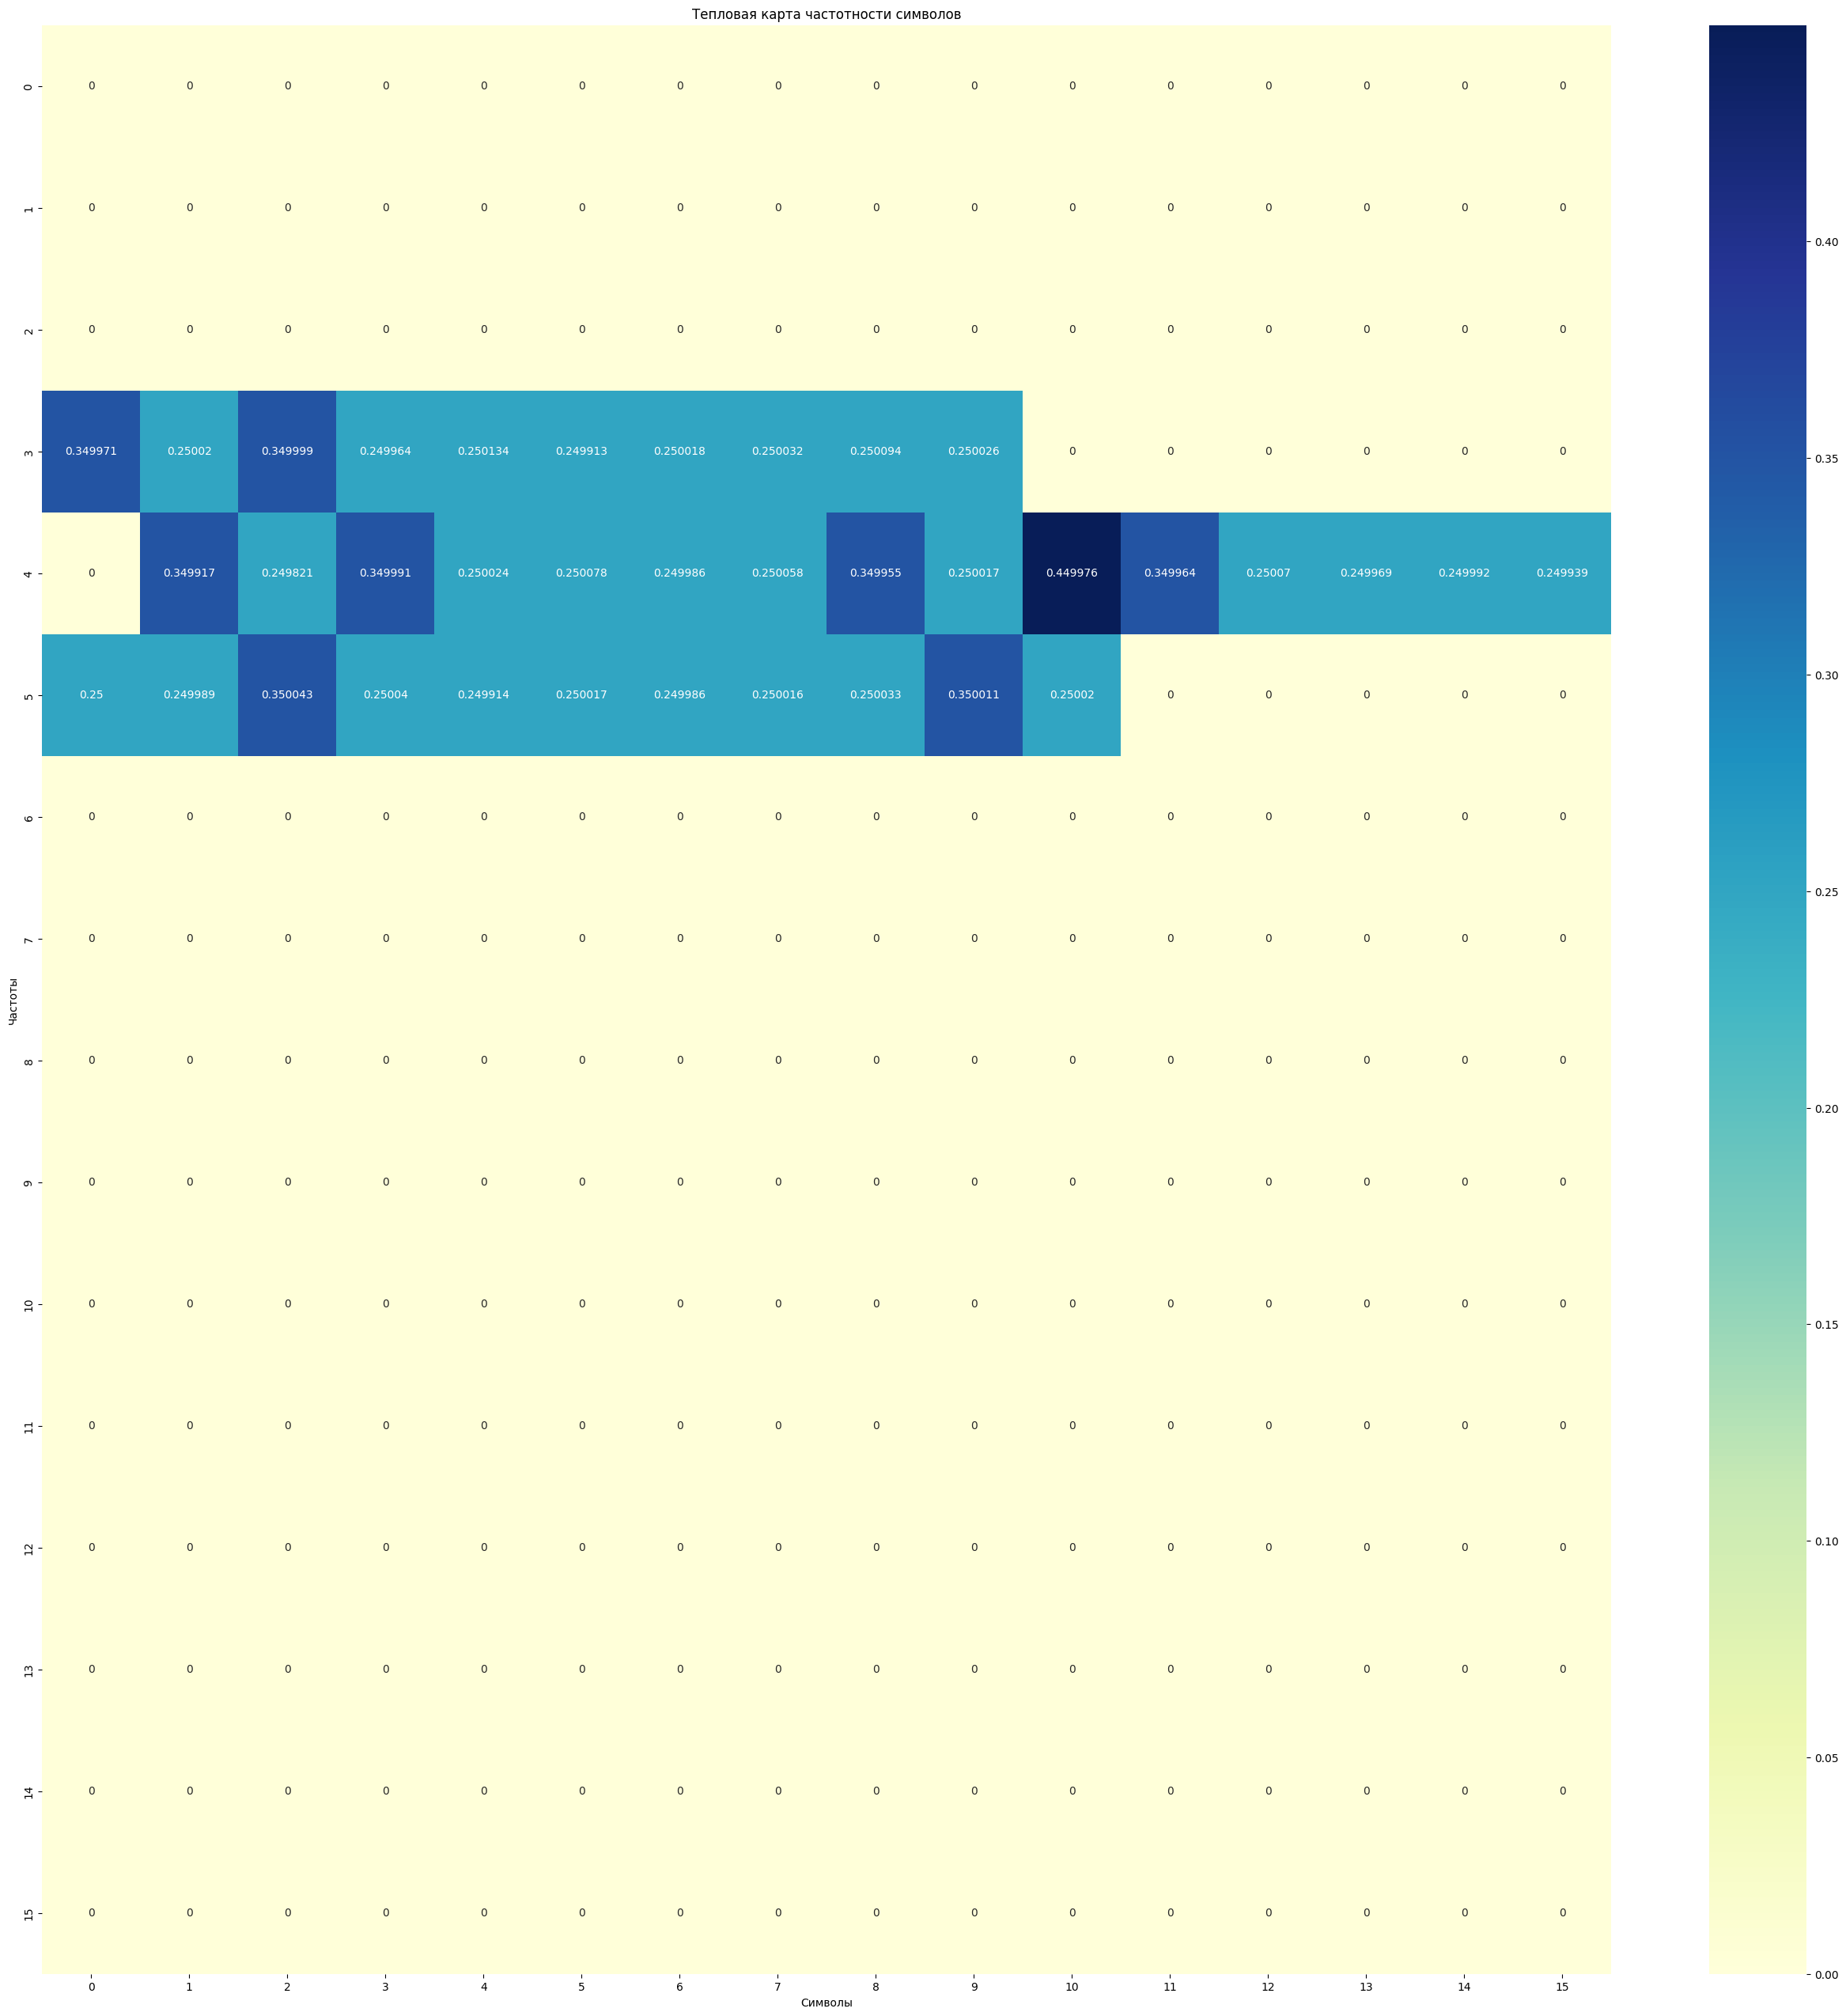

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp

def count_characters(chunk):
    """Подсчитываем частоту символов в строковом столбце."""
    counts = np.zeros(256, dtype=np.uint32)
    for row in chunk:
        for char in row:
            counts[ord(char)] += 1
    return counts

def build_heatmap(frequencies):
    """Строим тепловую карту частотности символов."""
    heatmap_data = frequencies.reshape(16, 16)
    f, ax = plt.subplots(figsize=(32, 32))
    ax = sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlGnBu')
    ax.set_title("Тепловая карта частотности символов")
    ax.set_xlabel("Символы")
    ax.set_ylabel("Частоты")

if __name__ == "__main__":
    # Чтение данных
    df = pd.read_csv('datasetfile.csv')

    # Параллельное вычисление частот символов
    cores = mp.cpu_count()
    pool = mp.Pool(cores)
    chunk_size = 10000000  # Размер куска данных для одного процесса
    chunks = [df['String'][i:i + chunk_size].values for i in range(0, len(df), chunk_size)]
    char_counts = pool.map(count_characters, chunks)

    # Объединение результатов
    total_char_counts = sum(char_counts)

    # Нормализуем данные
    normalized_char_counts = total_char_counts / len(df)

    # Строим тепловую карту
    build_heatmap(normalized_char_counts)

Дополнительное задание 1

In [16]:
# 1.Случайно поделить датасет на 3 части - в одной 25% записей, во второй 25% и 50% в третьей.
from sklearn.model_selection import train_test_split


train, test = train_test_split(df, test_size=0.5, random_state=42)
test1, test2 = train_test_split(test, test_size=0.5, random_state=42)

print("Размеры выборок:")
print(f"Тренировочная выборка: {len(train)}")
print(f"Первая тестовая выборка: {len(test1)}")
print(f"Вторая тестовая выборка: {len(test2)}")


Размеры выборок:
Тренировочная выборка: 50000000
Первая тестовая выборка: 25000000
Вторая тестовая выборка: 25000000


In [17]:
# 2.Проверить на статистическую значимость различий для среднего по колонке numeric

from scipy.stats import ttest_ind

mean_train = train['Numeric'].mean()
mean_test1 = test1['Numeric'].mean()
mean_test2 = test2['Numeric'].mean()

# T-тест между тренировочной и первой тестовой выборкой
t_statistic, p_value = ttest_ind(train['Numeric'], test1['Numeric'])
print(f"T-статистика: {t_statistic:.3f}, p-значение: {p_value:.3e}")

# Интерпретация p-value:
alpha = 0.05
if p_value > alpha:
    print("Нет статистически значимых различий между средними.")
else:
    print("Есть статистически значимые различия между средними (p-value < alpha).")

# Аналогично для второй тестовой выборки
t_statistic2, p_value2 = ttest_ind(train['Numeric'], test2['Numeric'])
print("\nT-статистика: {:.3f}, p-значение: {:.3e}".format(t_statistic2, p_value2))
if p_value2 > alpha:
    print("Нет статистически значимых различий между средними.")
else:
    print("Есть статистически значимое различие между средними значениями (p-значение < alpha)")

T-статистика: 1.013, p-значение: 3.109e-01
Нет статистически значимых различий между средними.

T-статистика: -0.744, p-значение: 4.571e-01
Нет статистически значимых различий между средними.


In [23]:
# 3.Оценить силу эффекта
import numpy as np

def cohen_d(group1, group2):
    # Среднее двух групп
    mean1, mean2 = np.mean(group1), np.mean(group2)

    # Расчет pooled стандартного отклонения
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))

    # Расчет Cohen's d
    d = (mean1 - mean2) / pooled_std

    return d

cohen_d1 = cohen_d(train['Numeric'], test1['Numeric'])
cohen_d2 = cohen_d(train['Numeric'], test2['Numeric'])

print(f"Коэффициент Коэна для первой тестовой выборки: {cohen_d1:.3f}")
print(f"Коэффициент Коэна для второй тестовой выборки: {cohen_d2:.3f}")

# Интерпретация коэффициентов Коэна:
if abs(cohen_d1) < 0.2:
    print("Маленький эффект")
elif abs(cohen_d1) >= 0.8:
    print("Большой эффект")
else:
    print("Средний эффект")

Коэффициент Коэна для первой тестовой выборки: 0.000
Коэффициент Коэна для второй тестовой выборки: -0.000
Маленький эффект


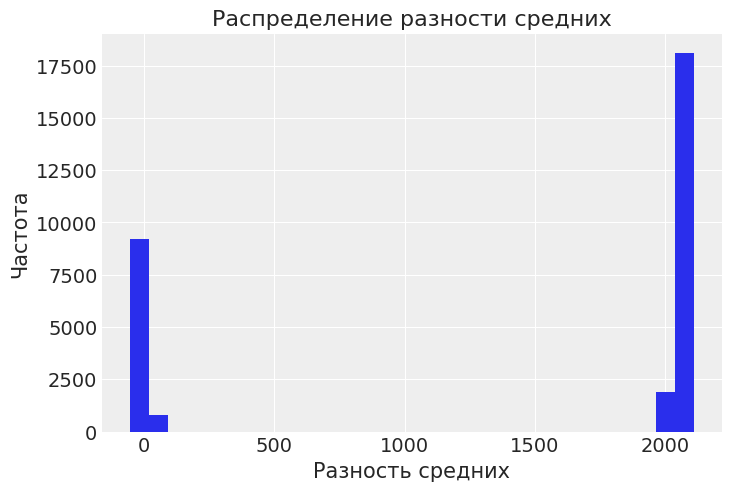

In [35]:
# 4.Проделать шаги 2 и 3 используя байесовский подход
import numpy as np
import multiprocessing as mp
from joblib import Parallel, delayed
from scipy.stats import norm

def bayesian_mean_comparison(samples, prior_mu=0, prior_sigma=10, iterations=10000, n_jobs=-1):
    # samples - список выборок (например, [sample1, sample2, sample3])
    num_samples = len(samples)

    if n_jobs is None or n_jobs == -1:
        n_jobs = mp.cpu_count()
    # Параллельное вычисление общего стандартного отклонения
    with mp.Pool(n_jobs) as pool:
        variances = pool.map(np.var, samples)

    # Среднее стандартное отклонение
    sigma = np.sqrt(sum(variances) / num_samples)

    # Параметры для генерации выборок
    priors = [(prior_mu / prior_sigma**2 + sum(s) / sigma**2) / (1 / prior_sigma**2 + len(s) / sigma**2) for s in samples]
    sigmas = [np.sqrt(1 / (1 / prior_sigma**2 + len(s) / sigma**2)) for s in samples]

    # Генерация выборок
    posterior_differences = []
    for _ in range(iterations):
        # Генерация выборок из нормальных распределений
        post_mus = [np.random.normal(mu, sig) for mu, sig in zip(priors, sigmas)]

        # Вычисление разности средних
        differences = []
        for i in range(num_samples):
            for j in range(i+1, num_samples):
                differences.append(post_mus[i] - post_mus[j])

        posterior_differences.extend(differences)

    return posterior_differences


# Подготовка данных
numeric_part1 = train['Numeric']
numeric_part2 = test1['Numeric']
numeric_part3 = test2['Numeric']
samples = [numeric_part1, numeric_part2, numeric_part3]

posterior_diffs = bayesian_mean_comparison(samples)

plt.hist(posterior_diffs, bins=30)
plt.title("Распределение разности средних")
plt.xlabel("Разность средних")
plt.ylabel("Частота")
plt.show()

Дополнительное задание 2

Предложим два возможных подхода к решению данной задачи.

### Метод 1: Биномиальное распределение и оценка максимального правдоподобия

#### Постановка задачи:
Мы знаем, что наша компания выпустила 200 прототипов, и ни один из них не оказался успешным. Конкурент выпустил 1000 прототипов, из которых 5 были успешны. Нам нужно найти вероятность того, что следующий (201-й) прототип нашей компании окажется успешным.

#### Решение:

1. **Модель биномиального распределения:**
   Каждый прототип можно рассматривать как независимый эксперимент с двумя исходами: успех или неудача. Вероятность успеха обозначим через $p$. Тогда количество успешных прототипов следует биномиальному распределению с параметрами $n$ (количество экспериментов) и $p$.

2. **Оценка максимального правдоподобия:**
   Мы можем использовать метод максимального правдоподобия для оценки вероятности успеха $p$ на основе имеющихся данных. Для нашего случая, когда ни одного успешного прототипа не было выпущено, максимальная правдоподобная оценка вероятности успеха равна нулю ($p = 0$). Это означает, что наиболее вероятно, что следующая игра тоже не будет успешной.

3. **Расчет вероятности:**
   Так как наша оценка вероятности успеха для следующей игры равна нулю, вероятность того, что 201-й прототип будет успешным, также равна нулю.

#### Заключение:
Используя биномиальную модель и метод максимального правдоподобия, мы пришли к выводу, что вероятность успеха 201-го прототипа равна нулю. Однако этот результат основан на предположении, что предыдущие эксперименты точно отражают истинную вероятность успеха, что может быть спорным.

### Метод 2: Байесовский подход

#### Постановка задачи:
Допустим, что мы хотим учесть неопределенность в оценке вероятности успеха и использовать байесовский подход для учета наших априорных знаний о вероятности успеха.

#### Решение:

1. **Выбор априорного распределения:**
   Начнем с выбора априорного распределения для вероятности успеха. Обычно используют бета-распределение, так как оно является сопряженным априором для биномиальной модели. Пусть наше априорное распределение будет $Beta(\alpha, \beta)$, где $\alpha$ и $\beta$ — гиперпараметры, которые определяют форму распределения.

2. **Обновление априори до апостериори:**
   Используя данные о том, что ни одна из 200 попыток не была успешной, мы можем обновить наше априорное распределение до апостериорного. Формула для обновления выглядит следующим образом:
   

$$ P(p | x) = Beta(x+\alpha, n-x+\beta) $$

   где $x$ — количество успехов, $n$ — общее количество испытаний, $\alpha$ и $\beta$ — параметры априорного распределения.

3. **Подстановка значений:**
   В нашем случае $x = 0$ (ни одного успеха), $n = 200$, и пусть $\alpha = 1$, $\beta = 1$ (неинформативное априорное распределение). Тогда апостериорное распределение становится $Beta(1, 201)$.

4. **Прогнозирование вероятности успеха следующего испытания:**
   Среднее значение бета-распределения $Beta(a, b)$ равно $\frac{a}{a+b}$. Таким образом, ожидаемая вероятность успеха для следующего испытания равна:
   

$$ E[p] = \frac{1}{1+201} = \frac{1}{202} \approx 0.00495 $$

#### Заключение:
Байесовский подход дает нам более гибкий способ оценки вероятности успеха, учитывая нашу уверенность в начальных оценках. В данном случае, ожидаемая вероятность того, что 201-й прототип будет успешным, составляет примерно 0.005.
